<a href="https://colab.research.google.com/github/valentina1702/EEG_autoencoder/blob/main/autoencoder_EEG_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation learning with Autoencoders

In this notebook, I tried to solve a 2-class classification problem using Epilespy EEG data.



The dataset is available from https://zenodo.org/record/3684992

This dataset was generated with a motive to build predictive epilepsy diagnosis models. It was generated on a similar acquisition and settings i.e., sampling frequency, bandpass filtering and number of signals and time duration as
its much more famous counterpart - the University of Bonn dataset. It has overcome the limitations faced by the University of Bonn dataset, such as different EEG recording sites (inter-cranial and scalp) for healthy and epileptic patients. All the data were taken exclusively using surface EEG electrodes.

In [ ]:
# load libraries; feel free to add more
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from google.colab import drive
from numpy import loadtxt
import keras
import glob
from keras.layers import Dense, Input, ReLU, Activation, Dropout, Conv1D, MaxPool1D, UpSampling1D, ZeroPadding1D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,auc
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install wget
import wget
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:

# YOUR CODE HERE

try:
    # Executes if running in Google Colab

    drive.mount('drive/')
    path = "drive/My Drive" 
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./"

Mounted at drive/


Create a new folder in your Google Drive to store the data, make that your current working directory and run the following code block to download all the dataset files. 

In [ ]:
# Download the dataset
for cat in ['E', 'H']: 
  for pid in range(1,6):
    for filenum in range(1,41):
      dataFile = 'Train' + cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

for cat in ['E', 'H']: 
  for pid in range(1,11):
    for filenum in range(1,21):
      dataFile = cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

TrainE1_2.txt
TrainE1_3.txt
TrainE1_4.txt
TrainE1_5.txt
TrainE1_6.txt
TrainE1_7.txt
TrainE1_8.txt
TrainE1_9.txt
TrainE1_10.txt
TrainE1_11.txt
TrainE1_12.txt
TrainE1_13.txt
TrainE1_14.txt
TrainE1_15.txt
TrainE1_16.txt
TrainE1_17.txt
TrainE1_18.txt
TrainE1_19.txt
TrainE1_20.txt
TrainE1_21.txt
TrainE1_22.txt
TrainE1_23.txt
TrainE1_24.txt
TrainE1_25.txt
TrainE1_26.txt
TrainE1_27.txt
TrainE1_28.txt
TrainE1_29.txt
TrainE1_30.txt
TrainE1_31.txt
TrainE1_32.txt
TrainE1_33.txt
TrainE1_34.txt
TrainE1_35.txt
TrainE1_36.txt
TrainE1_37.txt
TrainE1_38.txt
TrainE1_39.txt
TrainE1_40.txt
TrainE2_1.txt
TrainE2_2.txt
TrainE2_3.txt
TrainE2_4.txt
TrainE2_5.txt
TrainE2_6.txt
TrainE2_7.txt
TrainE2_8.txt
TrainE2_9.txt
TrainE2_10.txt
TrainE2_11.txt
TrainE2_12.txt
TrainE2_13.txt
TrainE2_14.txt
TrainE2_15.txt
TrainE2_16.txt
TrainE2_17.txt
TrainE2_18.txt
TrainE2_19.txt
TrainE2_20.txt
TrainE2_21.txt
TrainE2_22.txt
TrainE2_23.txt
TrainE2_24.txt
TrainE2_25.txt
TrainE2_26.txt
TrainE2_27.txt
TrainE2_28.txt
TrainE2_29.t

**Data Preparation** 


All the files starting with 'Train' along with the files starting with E1 to E8 and H1 to H8 were used as training data (that is a total of 26 participants.) 

Files of subjects E9, E10, H9 and H10 (4 participants) was used as validation data. 

Loaded all the EEG files into two data matrices for train and test. The matrices have dimensions N x S. Where is N is number of data points (~2800 for train and ~300 for test). 
A single data point corresponds to a contiguous S=868 sample length (about 5s given the sampling rate of 173.6 Hz) from an EEG file. These 5 second segments are non-overlapping portions from the datasets.

The labels should be 0 or 1 (epilepsy or healthy). 

Normalized all data to range of [-1,1] 

In [ ]:
# data preparation CODE HERE

#specify the path to the directory containing the data
directory = "EEGDataSingleElectrode"
dir_path = r'/'.join((path,directory))
#get the list of filenames in the directory 
file_names_lst = os.listdir(dir_path)

#specify paths to find files with specific descriptions for glob search
d1 = dir_path + "/TrainE*.txt"
d2 = dir_path + "/TrainH*.txt"
e = dir_path + "/E[1-8]_*.txt"
h = dir_path + "/H[1-8]_*.txt"
e2 = dir_path + "/E9*.txt"
h2 = dir_path + "/H9*.txt"
e3 = dir_path + "/E10*.txt"
h3 = dir_path + "/H10*.txt"
r = glob.glob(d1)
r1 = glob.glob(d2)
r2 = glob.glob(e)
r3 = glob.glob(h)
r4 = glob.glob(e2)
r5 = glob.glob(h2)
r6 = glob.glob(e3)
r7 = glob.glob(h3)
#concatenate lists with paths for training data
train_list = r + r1 + r2 + r3
#concatenate lists with paths for testing data
test_list = r4 + r6 + r5 + r7



In [ ]:
#empty list for appending labels
label_train= []

#loop through all paths in train_list, load the data, and reshape it to have 4 frames from each file, and concatenate matrices of each file, and append label 4 times for 4 frames,
#label depends on the list the path belonged to, if it was having path name with E or H
for i in range(len(train_list)):
  if i==0:
    lines = loadtxt(train_list[i], delimiter="\n", unpack=True)
    lines = lines[:3472]
    train_matrix = lines.reshape(4,868)
    if train_list[i] in r or train_list[i] in r2 or train_list[i] in r4 or train_list[i] in r6: 
      label_train.append(0)
      label_train.append(0)
      label_train.append(0)
      label_train.append(0)
    if train_list[i] in r1 or train_list[i] in r3 or train_list[i] in r5 or train_list[i] in r7: 
      label_train.append(1)
      label_train.append(1)
      label_train.append(1)
      label_train.append(1)
  else:
    lines = loadtxt(train_list[i], delimiter="\n", unpack=True)
    lines = lines[:3472]
    a = lines.reshape(4,868)
    if train_list[i] in r or train_list[i] in r2 or train_list[i] in r4 or train_list[i] in r6: 
      label_train.append(0)
      label_train.append(0)
      label_train.append(0)
      label_train.append(0)
    if train_list[i] in r1 or train_list[i] in r3 or train_list[i] in r5 or train_list[i] in r7: 
      label_train.append(1)
      label_train.append(1)
      label_train.append(1)
      label_train.append(1)
    train_matrix = np.concatenate((train_matrix,a))     


In [ ]:
#empty list for appending labels
label_test= []

#loop through all paths in valid_list, load the data, and reshape it to have 4 frames from each file, and concatenate matrices of each file, and append label 4 times for 4 frames,
#label depends on the list the path belonged to, if it was having path name with E or H

for i in range(len(test_list)):
  if i==0:
    lines = loadtxt(test_list[i], delimiter="\n", unpack=True)
    lines = lines[:3472]
    test_matrix = lines.reshape(4,868)
    if test_list[i] in r or test_list[i] in r2 or test_list[i] in r4 or test_list[i] in r6: 
      label_test.append(0)
      label_test.append(0)
      label_test.append(0)
      label_test.append(0)
    elif test_list[i] in r1 or test_list[i] in r3 or test_list[i] in r5 or test_list[i] in r7: 
      label_test.append(1)
      label_test.append(1)
      label_test.append(1)
      label_test.append(1)
  else:
    lines = loadtxt(test_list[i], delimiter="\n", unpack=True)
    lines = lines[:3472]
    a = lines.reshape(4,868)
    if test_list[i] in r or test_list[i] in r2 or test_list[i] in r4 or test_list[i] in r6: 
      label_test.append(0)
      label_test.append(0)
      label_test.append(0)
      label_test.append(0)
    elif test_list[i] in r1 or test_list[i] in r3 or test_list[i] in r5 or test_list[i] in r7: 
      label_test.append(1)
      label_test.append(1)
      label_test.append(1)
      label_test.append(1)
    test_matrix = np.concatenate((test_matrix,a))     


In [ ]:
#function to normalize data
#divides the data with maximum value of the absolute values
def NormalizeData(data):
  return data/(np.max(np.abs(data),axis=0))
train_normalized = NormalizeData(train_matrix)
test_normalized = NormalizeData(test_matrix)


In [ ]:
#convert labels to categorical
y = to_categorical(label_train, 2)
y_true = to_categorical(label_test, 2)

**Auto-encoder training** 
Created an autoencoder based on the analysis methodology described in this paper. 
https://www.sciencedirect.com/science/article/pii/S0957417420306114

Using Keras, created and trained the auto-encoder specified in the paper.
An autoencoder is a specific type of a neural network, which is mainly designed to encode the input into a compressed and meaningful representation, and then decode it back such that the reconstructed input is similar as possible to the original one.
Chose MSE (mean squared error) as loss function.


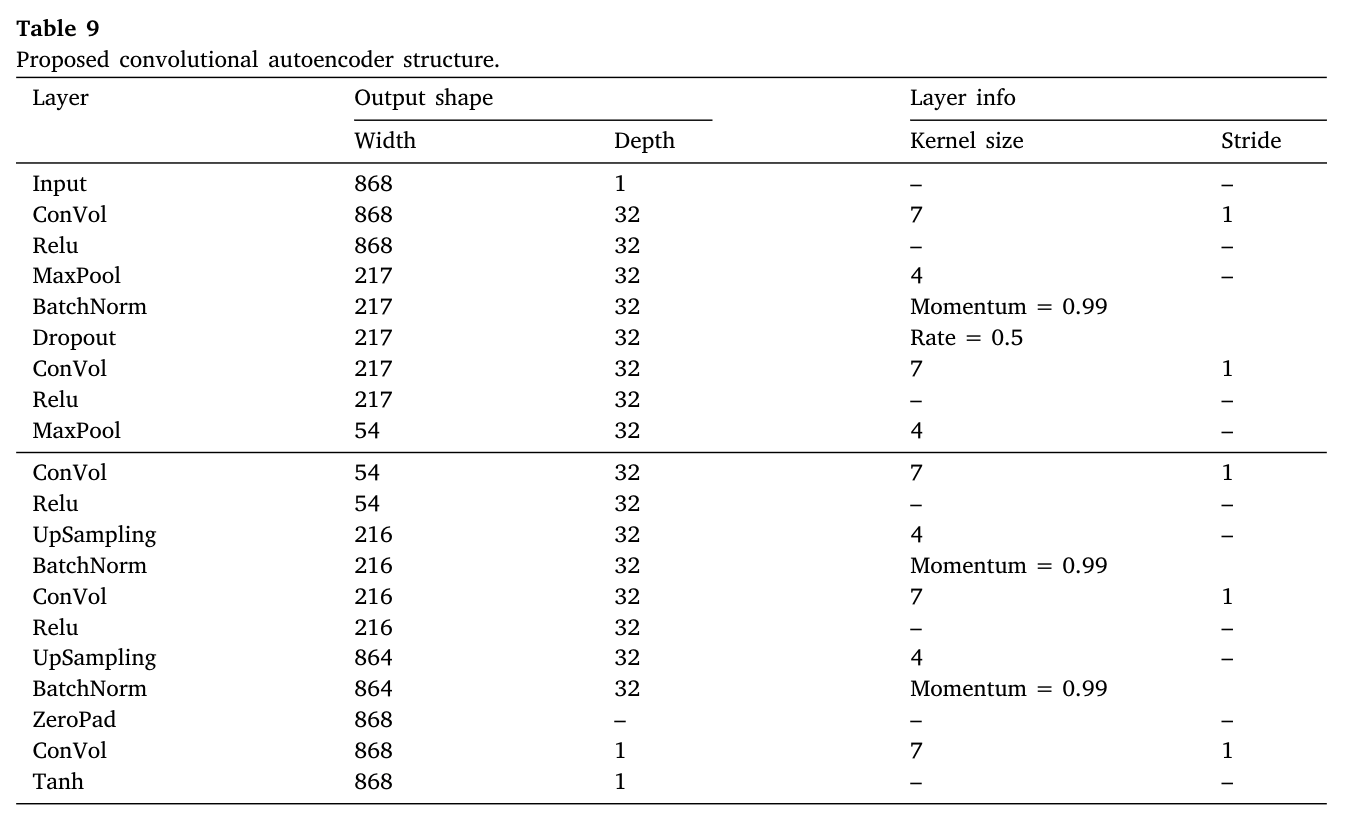

In [ ]:

# autoencoder training CODE HERE
encoder = Sequential([
    Input(shape = (868,1)),
    Conv1D(filters=32,kernel_size=7, strides = 1,padding = "same"),
    ReLU(),
    MaxPool1D(pool_size=4),
    BatchNormalization(momentum=0.99),
    Dropout(rate = 0.5),
    Conv1D(filters=32,kernel_size=1,strides = 1),
    ReLU(),
    MaxPool1D(pool_size=4)
])

decoder = Sequential([
    Input(shape = (54,32)),
    Conv1D(filters=32,kernel_size=7, strides = 1, padding = "same"),
    ReLU(),
    UpSampling1D(size=4),
    BatchNormalization(momentum=0.99),
    Conv1D(filters=32,kernel_size=7,strides = 1,padding = "same"),
    ReLU(),
    UpSampling1D(size=4),
    BatchNormalization(momentum=0.99),
    ZeroPadding1D(padding = 2),
    Conv1D(filters=1,kernel_size=7,strides = 1,padding = "same"),
    Activation("tanh"),
])

encoder.summary()
decoder.summary()
data= Input(shape = (868,1))
latent_vector = encoder(data)
output = decoder(latent_vector)
autoencoder = Model(inputs = data, outputs = output)
autoencoder.summary()
es = EarlyStopping(monitor='loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
autoencoder.compile(optimizer = "adam", loss = "MSE", metrics=['MeanSquaredError'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 868, 32)           256       
                                                                 
 re_lu (ReLU)                (None, 868, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 217, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 217, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 217, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 217, 32)           1

In [ ]:
#fit the autoencoder on train-matrix
autoencoder.fit(train_normalized, train_normalized,epochs=50, batch_size=64, callbacks=[es],verbose=2)

Epoch 1/50
45/45 - 16s - loss: 0.0850 - mean_squared_error: 0.0850 - 16s/epoch - 344ms/step
Epoch 2/50
45/45 - 1s - loss: 0.0162 - mean_squared_error: 0.0162 - 839ms/epoch - 19ms/step
Epoch 3/50
45/45 - 1s - loss: 0.0134 - mean_squared_error: 0.0134 - 845ms/epoch - 19ms/step
Epoch 4/50
45/45 - 1s - loss: 0.0124 - mean_squared_error: 0.0124 - 844ms/epoch - 19ms/step
Epoch 5/50
45/45 - 1s - loss: 0.0116 - mean_squared_error: 0.0116 - 847ms/epoch - 19ms/step
Epoch 6/50
45/45 - 1s - loss: 0.0110 - mean_squared_error: 0.0110 - 848ms/epoch - 19ms/step
Epoch 7/50
45/45 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - 838ms/epoch - 19ms/step
Epoch 8/50
45/45 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - 832ms/epoch - 18ms/step
Epoch 9/50
45/45 - 1s - loss: 0.0096 - mean_squared_error: 0.0096 - 837ms/epoch - 19ms/step
Epoch 10/50
45/45 - 1s - loss: 0.0093 - mean_squared_error: 0.0093 - 835ms/epoch - 19ms/step
Epoch 11/50
45/45 - 1s - loss: 0.0090 - mean_squared_error: 0.0090 - 837ms/epoc

**Visualization of reconstruction** 
Let x be a 868-sample long data point from the test set, e() be encoder, d() be decoder. The reconstuction/auto-encoding of x is given by d(e(x)) i.e. simply forward pass of x through the auto-encoder. 


Dimensionality of original signal is  868
It is multidimensional and it's encoding dimension is  1728


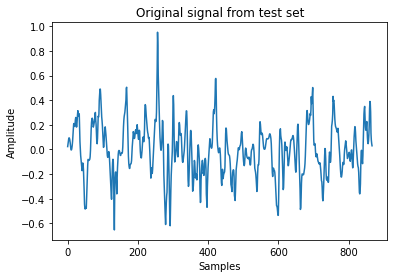

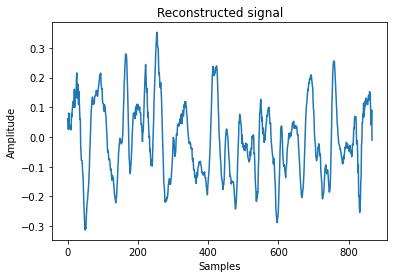

In [ ]:
# visualization of reconstruction CODE HERE
plt.figure()
plt.title("Original signal from test set")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.plot(test_normalized[1])
recon = decoder(encoder(test_normalized))
plt.figure()
plt.title("Reconstructed signal")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.plot(recon[1])
print("Dimensionality of original signal is ",np.prod(test_normalized[1].shape))
if len(encoder(test_normalized)[1].shape)>1:
  print("It is multidimensional and it's encoding dimension is ",np.prod(encoder(test_normalized)[1].shape))
else:
  print("It is not multidimensional and it's encoding dimension is ",encoder(test_normalized)[1].shape)

**Training classifier**: 
Discarding the decoder, appended a simple classifier at the end of the trained encoder. The classifier (excluding encoder) is a M=100 unit dense layer followed by an activation function followed by 2-class softmax classification. Encoder was frozen in this training.

In [ ]:
# training classifier CODE HERE
#freeze encoder part
for layer in encoder.layers:
  layer.trainable = False
#append classifier to encoder
classifier = Sequential()
classifier.add(Input(shape=(868,1)))
classifier.add(encoder)
classifier.add(Flatten())
classifier.add(Dense(100,activation="relu"))
classifier.add(Dense(2,activation="softmax"))
classifier.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 54, 32)            1440      
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 100)               172900    
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 174,542
Trainable params: 173,102
Non-trainable params: 1,440
_________________________________________________________________


In [ ]:
classifier.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])


In [ ]:
#fit the classifier on train-matrix
classifier.fit(train_normalized, y,epochs=50, batch_size=64, verbose=2,callbacks=[es])

Epoch 1/50
45/45 - 1s - loss: 0.7292 - accuracy: 0.6156 - 975ms/epoch - 22ms/step
Epoch 2/50
45/45 - 0s - loss: 0.5462 - accuracy: 0.7431 - 208ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.5131 - accuracy: 0.7490 - 204ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.4861 - accuracy: 0.7691 - 195ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.4695 - accuracy: 0.7799 - 208ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.4631 - accuracy: 0.7778 - 202ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.4354 - accuracy: 0.7972 - 201ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.4253 - accuracy: 0.8024 - 200ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.4230 - accuracy: 0.8073 - 203ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.4015 - accuracy: 0.8094 - 197ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.4165 - accuracy: 0.8035 - 191ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.4152 - accuracy: 0.8038 - 186ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s -

In [ ]:
#Find accuracy on test data
preds = classifier.predict(test_normalized)
preds = np.argmax(preds,-1)

print("Accuracy is:",accuracy_score(label_test, preds)) 
print(classification_report(label_test, preds))


Accuracy is: 0.628125
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       160
           1       0.66      0.53      0.59       160

    accuracy                           0.63       320
   macro avg       0.63      0.63      0.62       320
weighted avg       0.63      0.63      0.62       320



**Accuracy on test dataset is 62.81%**

**Modifying bottleneck of auto-encoder**: 
Treated K (encoded dimension) a as hyper-parameter. Goal was to ensure K is approximately half of signal length i.e. 868/2 = 434. 

**The reconstructed signal looks more like the original signal now. It did not alter the dimensions too much, altered only by a factor of 0.5, so it mostly possible that it is not learning much and just mimicing the original signal, which is relflected with low accuracy in the classification than the previous task**

In [ ]:

# modifying bottleneck part 1 CODE HERE
#changed the pool_size of first layer in encoder part and removed last pooling layer
encoder2 = Sequential([
    Input(shape = (868,1)),
    Conv1D(filters=32,kernel_size=7, strides = 1,padding = "same"),
    ReLU(),
    MaxPool1D(pool_size=2),
    BatchNormalization(momentum=0.99),
    Dropout(rate = 0.5),
    Conv1D(filters=32,kernel_size=1,strides = 1),
    ReLU()
])

#removed zero-padding layer and changed up-sampling layer size
decoder2 = Sequential([
    Input(shape = (434,32)),
    Conv1D(filters=32,kernel_size=7, strides = 1, padding = "same"),
    ReLU(),
    UpSampling1D(size=1),
    BatchNormalization(momentum=0.99),
    Conv1D(filters=32,kernel_size=7,strides = 1,padding = "same"),
    ReLU(),
    UpSampling1D(size=2),
    BatchNormalization(momentum=0.99),
    Conv1D(filters=1,kernel_size=7,strides = 1,padding = "same"),
    Activation("tanh"),
])

encoder2.summary()
decoder2.summary()
data= Input(shape = (868,1))
latent_vector = encoder2(data)
output = decoder2(latent_vector)
autoencoder_modified = Model(inputs = data, outputs = output)
autoencoder_modified.summary()


autoencoder_modified.compile(optimizer = "adam", loss = "MSE", metrics=['MeanSquaredError'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 868, 32)           256       
                                                                 
 re_lu_4 (ReLU)              (None, 868, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 434, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 434, 32)          128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 434, 32)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 434, 32)          

In [ ]:
#fit the modified encoder on tarin-matrix
autoencoder_modified.fit(train_normalized, train_normalized,epochs=50, batch_size=64, callbacks=[es],verbose=2)

Epoch 1/50
45/45 - 6s - loss: 0.0844 - mean_squared_error: 0.0844 - 6s/epoch - 130ms/step
Epoch 2/50
45/45 - 1s - loss: 0.0075 - mean_squared_error: 0.0075 - 1s/epoch - 25ms/step
Epoch 3/50
45/45 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - 1s/epoch - 25ms/step
Epoch 4/50
45/45 - 1s - loss: 0.0045 - mean_squared_error: 0.0045 - 1s/epoch - 25ms/step
Epoch 5/50
45/45 - 1s - loss: 0.0037 - mean_squared_error: 0.0037 - 1s/epoch - 25ms/step
Epoch 6/50
45/45 - 1s - loss: 0.0029 - mean_squared_error: 0.0029 - 1s/epoch - 25ms/step
Epoch 7/50
45/45 - 1s - loss: 0.0023 - mean_squared_error: 0.0023 - 1s/epoch - 25ms/step
Epoch 8/50
45/45 - 1s - loss: 0.0021 - mean_squared_error: 0.0021 - 1s/epoch - 25ms/step
Epoch 9/50
45/45 - 1s - loss: 0.0017 - mean_squared_error: 0.0017 - 1s/epoch - 25ms/step
Epoch 10/50
45/45 - 1s - loss: 0.0018 - mean_squared_error: 0.0018 - 1s/epoch - 25ms/step
Epoch 11/50
45/45 - 1s - loss: 0.0016 - mean_squared_error: 0.0016 - 1s/epoch - 25ms/step
Epoch 12/50
45/45 

In [ ]:
# training classifier part 1 CODE HERE

#freeze the encoder part
for layer in encoder2.layers:
  layer.trainable = False
#append classifier to encoder
classifier2 = Sequential()
classifier2.add(Input(shape=(868,1)))
classifier2.add(encoder2)
classifier2.add(Flatten())
classifier2.add(Dense(100,activation="relu"))
classifier2.add(Dense(2,activation="softmax"))

classifier2.summary()
classifier2.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
#fit the model
classifier2.fit(train_normalized, y,epochs=50, batch_size=64, verbose=2,callbacks=[es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 434, 32)           1440      
                                                                 
 flatten_2 (Flatten)         (None, 13888)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               1388900   
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,390,542
Trainable params: 1,389,102
Non-trainable params: 1,440
_________________________________________________________________
Epoch 1/50
45/45 - 1s - loss: 0.8030 - accuracy: 0.6146 - 887ms/epoch - 20ms/step
Epoch 2/50
45/45 - 0s - loss: 0.5260 - accuracy: 0.7406 - 260ms/epoch - 6ms/step
Epoch 3/5

In [ ]:
#Report test accuracy
preds2 = classifier2.predict(test_normalized)
preds2 = np.argmax(preds2,-1)

print("Accuracy is: ",accuracy_score(label_test, preds2)) 
print(classification_report(label_test, preds2))


Accuracy is:  0.5625
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       160
           1       0.60      0.38      0.47       160

    accuracy                           0.56       320
   macro avg       0.57      0.56      0.55       320
weighted avg       0.57      0.56      0.55       320



Dimensionality of original signal is  868
It is multidimensional and it's encoding dimension is  13888


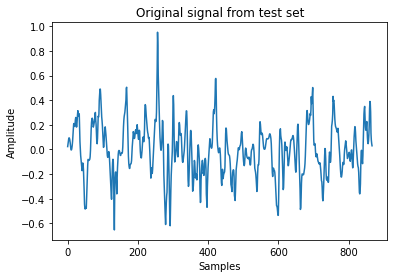

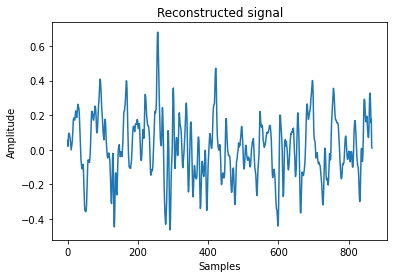

In [ ]:
# visualization part 1 CODE HERE
plt.figure()
plt.title("Original signal from test set")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.plot(test_normalized[1])
recon = decoder2(encoder2(test_normalized))
plt.figure()
plt.title("Reconstructed signal")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.plot(recon[1])
print("Dimensionality of original signal is ",np.prod(test_normalized[1].shape))
if len(encoder(test_normalized)[1].shape)>1:
  print("It is multidimensional and it's encoding dimension is ",np.prod(encoder2(test_normalized)[1].shape))
else:
  print("It is not multidimensional and it's encoding dimension is ",encoder2(test_normalized)[1].shape)


**T-SNE visualization**:  
Plotted the t-SNE visualization (https://opentsne.readthedocs.io/) of the representations of training data learned by the auto-encoders. Used different colors for data from different classes. 
Repeated this visualization but now used a different color per participant (each participant has several files and frames and will have several points in the TSNE plot). 

**Here we used encoder to reduce our data to a low-dimensional space first and then used T-SNE to map the compressed data to 2D plane. The healthy controls seem to be clustered together, but clustering is overlapped with healthy controls for epileptic patients, which also can be due to complexity of the dataset, given that the EEG signals were not from the time when they had seizures**

In [ ]:
#generate a list with different values for each individual participant, which would help in adding colour participant wise to TSNE plot
patient_train =[i for i in range(0,10)]
patient_train = [ele for ele in patient_train for i in range(40*4)]
patient_E =[i for i in range(10,18)]
patient_E = [ele for ele in patient_E for i in range(20*4)]
patient_H =[i for i in range(18,26)]
patient_H = [ele for ele in patient_H for i in range(20*4)]


files = patient_train + patient_E + patient_H


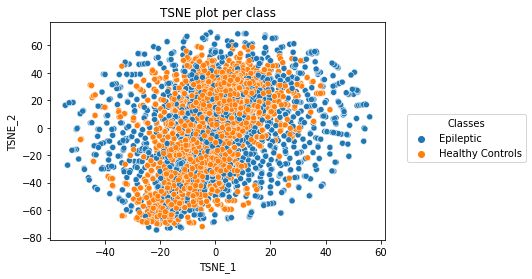

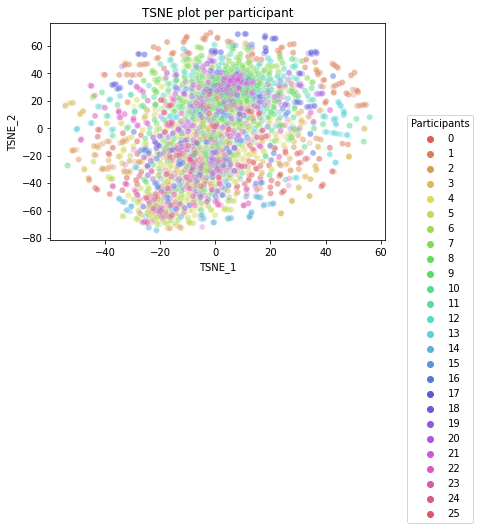

In [ ]:
#part2
#find representations learned by the encoder
#reshape to make it 2D
samples,x,y = encoder(train_normalized).shape
X = encoder(train_normalized).numpy()
X = X.reshape((samples,x*y))
#find embeddings and fit it 
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
#scatter plot of embeddings
labels = ["Healthy Controls" if i==1 else "Epileptic" for i in label_train]
#plot per class
plt.figure()
p1 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1],hue = labels )
plt.legend(title = "Classes", bbox_to_anchor = (1.05, 0.6))
p1.set(xlabel = "TSNE_1", ylabel = "TSNE_2", title = "TSNE plot per class")
#plot per participant
plt.figure()
p2 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1],hue = files,palette=sns.color_palette("hls", 26),alpha=0.3)
plt.legend(title = "Participants", bbox_to_anchor = (1.05, 0.6))
p2.set(xlabel = "TSNE_1", ylabel = "TSNE_2", title = "TSNE plot per participant")
plt.show()

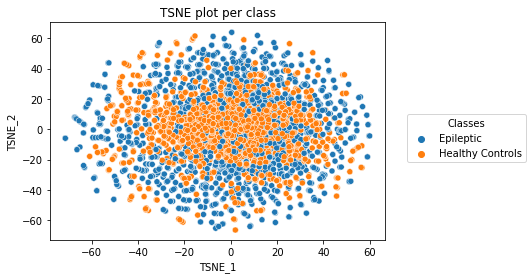

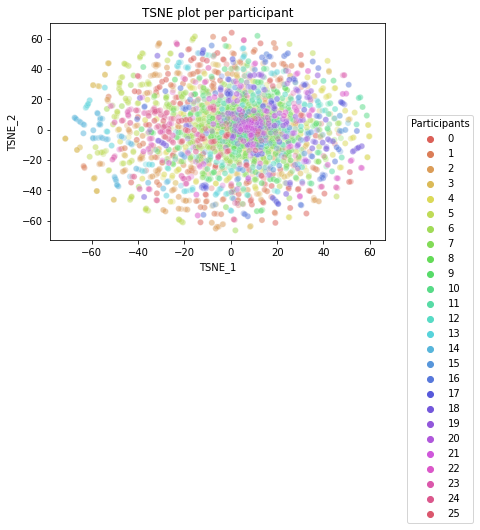

In [ ]:
#part5
#find representations learned by the encoder
samples,x,y = encoder2(train_normalized).shape
#reshape to make it 2D
X = encoder2(train_normalized).numpy()
X = X.reshape((samples,x*y))
#find embeddings and fit it 
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
#scatter plot of embeddings
#plot per class
plt.figure()
p1 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1],hue = labels )
plt.legend(title = "Classes", bbox_to_anchor = (1.05, 0.6))
p1.set(xlabel = "TSNE_1", ylabel = "TSNE_2", title = "TSNE plot per class")
#plot per participant
plt.figure()
p2 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1],hue = files,palette=sns.color_palette("hls", 26),alpha=0.3)
plt.legend(title = "Participants", bbox_to_anchor = (1.05, 0.6))
p2.set(xlabel = "TSNE_1", ylabel = "TSNE_2", title = "TSNE plot per participant")
plt.show()

In the previous tasks, I have calculated the *frame-wise* validation accuracy. Now I willl try to calculate the *file-wise* and *participant-wise* validation accuracy of parts 2 and 5, considering that each file has several frames. 


**The file-wise accuracy is lower than the frame-wise accuracy. This is because if maybe we look at all frames of a file, majority might indicate a condition which was picked by the file-wise classifier, but other frames that did not account for that condition and suggested a different condition was picked by frame-wise classifier to belong to that class which might have given better accuracy. But File-wise accuracy seems more intuitive than the frame-wise accuracy.  
For patient wise accuracy, I do not think the method I used is the right way to go about it, and it might give a false represenation of the accuracy, since we are averaging over many files. But in general patient-wise accuarcy gives more information than file-wise or frame-wise accuracy.**

In [ ]:
#part4
#filewise
#predict scores on training data to find eer_threshold
pred_train = classifier.predict(train_normalized)
pred_train_1 = np.argmax(pred_train,-1)
#compute fpr, tpr, threshold values
fpr, tpr, threshold = roc_curve(label_train, pred_train[:,0])
fnr = 1 - tpr
#find eer
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
#average scores for every patient, and also average labels to have one label per patient and store it in lists
new_preds = []
label_test_per=[]
for i in range(len(preds)-4):
  sum = (preds[i]+preds[i+1]+preds[i+2]+preds[i+3])/4
  sum2 = (label_test[i]+label_test[i+1]+label_test[i+2]+label_test[i+3])/4
  new_preds.append(sum)
  label_test_per.append(int(sum2))

#threshold scores
thresholded_preds = [1 if i>eer_threshold else 0 for i in new_preds]
#find accuracy
print("File wise Accuracy for part4 is: ",accuracy_score(label_test_per, thresholded_preds))



File wise Accuracy for part4 is:  0.6012658227848101


In [ ]:
#part5
#filewise
#predict scores on training data to find eer_threshold
pred_train = classifier2.predict(train_normalized)
pred_train_1 = np.argmax(pred_train,-1)
#compute fpr, tpr, threshold values
fpr, tpr, threshold = roc_curve(label_train, pred_train[:,0])
fnr = 1 - tpr
#find eer
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

#average scores for every file, and also average labels to have one label per patient and store it in lists
new_preds = []
label_test_per=[]
for i in range(len(preds2)-4):
  sum = (preds2[i]+preds2[i+1]+preds2[i+2]+preds2[i+3])/4
  sum2 = (label_test[i]+label_test[i+1]+label_test[i+2]+label_test[i+3])/4
  new_preds.append(sum)
  label_test_per.append(int(sum2))
#threhold scores
thresholded_preds = [1 if i> eer_threshold else 0 for i in new_preds]
#find accuracy
print("File wise Accuracy for part5 is: ",accuracy_score(label_test_per, thresholded_preds))


File wise Accuracy for part5 is:  0.509493670886076


In [ ]:
#part4
#patientwise
#predict scores on training data to find eer_threshold
pred_train = classifier.predict(train_normalized)
pred_train_1 = np.argmax(pred_train,-1)
#compute fpr, tpr, threshold values
fpr, tpr, threshold = roc_curve(label_train, pred_train[:,0])
fnr = 1 - tpr
#find eer
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
#average scores for every patient, and also average labels to have one label per patient
patient1_preds = np.sum(preds[0:80])/80
patient1_labels = np.sum(label_test[0:80])/80
patient2_preds = np.sum(preds[80:160])/80
patient2_labels = np.sum(label_test[80:160])/80
patient3_preds = np.sum(preds[160:240])/80
patient3_labels = np.sum(label_test[160:240])/80
patient4_preds = np.sum(preds[240:320])/80
patient4_labels = np.sum(label_test[240:320])/80
#lists with scores and labels for each patient
patient_preds = [patient1_preds,patient2_preds,patient3_preds,patient4_preds]
patient_labels=[patient1_labels,patient2_labels,patient3_labels,patient4_labels]
#threshold scores
thresholded_preds = [1 if i> eer_threshold else 0 for i in patient_preds]
#find accuracy
print("Patient wise Accuracy for part4 is: ",accuracy_score(patient_labels, thresholded_preds))

Patient wise Accuracy for part4 is:  0.5


In [ ]:
#part5
#patientwise
#predict scores on training data to find eer_threshold
pred_train = classifier2.predict(train_normalized)
pred_train_1 = np.argmax(pred_train,-1)
#compute fpr, tpr, threshold values
fpr, tpr, threshold = roc_curve(label_train, pred_train[:,0])
fnr = 1 - tpr
#find eer
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
#average scores for every patient, and also average labels to have one label per patient
patient1_preds = np.sum(preds[0:80])/80
patient1_labels = np.sum(label_test[0:80])/80
patient2_preds = np.sum(preds[80:160])/80
patient2_labels = np.sum(label_test[80:160])/80
patient3_preds = np.sum(preds[160:240])/80
patient3_labels = np.sum(label_test[160:240])/80
patient4_preds = np.sum(preds[240:320])/80
patient4_labels = np.sum(label_test[240:320])/80
#lists with scores and labels for each patient
patient_preds = [patient1_preds,patient2_preds,patient3_preds,patient4_preds]
patient_labels=[patient1_labels,patient2_labels,patient3_labels,patient4_labels]

#threshold scores
thresholded_preds = [1 if i> eer_threshold else 0 for i in patient_preds]
#find accuracy
print("Patient wise Accuracy for part5 is: ",accuracy_score(patient_labels, thresholded_preds))

Patient wise Accuracy for part5 is:  0.75
